In [1]:
import os
import sys
sys.path.append('../')
from semantic_segmentation import Segmentor
from convert_ckpt_to_pb import model_to_graph
from PIL import Image
import numpy as np

import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import time
from utils.average_meter import FPSMeter

DATA_ROOT = '/media/DATA/UnrealLandingDataset/AirSimCollectData'
IMAGE_ROOT = '/media/DATA/UnrealLandingDataset/AirSimCollectData/image'
LABEL_ROOT = '/media/DATA/UnrealLandingDataset/AirSimCollectData/label'
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
class arguments():
    model = 'FCN8sMobileNet'#'FCN8sShuffleNet'#'FCN8sMobileNet'#'UNetMobileNet' #UNetShuffleNet
    mode = 'inference'
    operator = 'Train'
    
    # Directories arguments
    data_dir = "/media/DATA/UnrealLandingDataset/AirSimCollectData/LidarRoofManualTest/" # CV_Random_Histogram/ CV_Manual/
    exp_dir =  "fcn8s_mobilenet"#"unet_mobilenet"#"fcn8s_shufflenet"#"fcn8s_mobilenet" # unet_shufflenet
    out_dir = "fcn8s_mobilenet"#"unet_mobilenet"#"fcn8s_shufflenet"#"fcn8s_mobilenet" # unet_shufflenet

    # Data arguments
    img_height = 512
    img_width = 512 
    num_channels = 3
    num_classes = 18
    
    # Train arguments
    num_epochs = 1 
    batch_size = 1
    shuffle = False
    data_mode = "test"
    save_every = 5
    test_every = 5
    max_to_keep = 5
    weighted_loss = False
    random_cropping = False

    # Models arguments
    learning_rate = 0.0001
    weight_decay = 0.0005
    pretrained_path = "../pretrained_weights/mobilenet_v1.pkl"#shufflenet_weights.pkl" #mobilenet_v1.pkl"
    batchnorm_enabled = True
    num_groups = 3
    bias = 0.0
    # Misc arguments
    verbose = False
    
    checkpoint_best_dir = '/home/nvidia/Documents/TFSegmentation/experiments/fcn8s_mobilenet/checkpoints/best'
#     checkpoint_best_dir = '/home/nvidia/Documents/TFSegmentation/experiments/fcn8s_mobilenet/train_val_checkpoints/checkpoints/best'

#     checkpoint_dir = '/home/nvidia/Documents/TFSegmentation/experiments/fcn8s_shufflenet/checkpoints'
#     checkpoint_best_dir = '/home/nvidia/Documents/TFSegmentation/experiments/fcn8s_shufflenet/checkpoints/best'
    
#     checkpoint_dir = '/home/nvidia/Documents/TFSegmentation/experiments/unet_mobilenet/checkpoints'
#     checkpoint_best_dir = '/home/nvidia/Documents/TFSegmentation/experiments/unet_mobilenet/checkpoints/best'

#     checkpoint_best_dir = '/home/nvidia/Documents/TFSegmentation/experiments/unet_shufflenet/checkpoints/best'
    summary_dir = 'temp_summary'
args = arguments()

In [5]:
model = Segmentor(args)

Building Test Network...

Building the MODEL...
Building the MobileNet..
Layer_name: network/mobilenet_encoder/conv_1/Relu6 -Output_Shape: [1, 256, 256, 32]
Layer_name: network/mobilenet_encoder/conv_ds_2/pointwise/Relu6 -Output_Shape: [1, 256, 256, 64]
Layer_name: network/mobilenet_encoder/conv_ds_3/pointwise/Relu6 -Output_Shape: [1, 128, 128, 128]
Layer_name: network/mobilenet_encoder/conv_ds_4/pointwise/Relu6 -Output_Shape: [1, 128, 128, 128]
Layer_name: network/mobilenet_encoder/conv_ds_5/pointwise/Relu6 -Output_Shape: [1, 64, 64, 256]
Layer_name: network/mobilenet_encoder/conv_ds_6/pointwise/Relu6 -Output_Shape: [1, 64, 64, 256]
Layer_name: network/mobilenet_encoder/conv_ds_7/pointwise/Relu6 -Output_Shape: [1, 32, 32, 512]
Layer_name: network/mobilenet_encoder/conv_ds_8/pointwise/Relu6 -Output_Shape: [1, 32, 32, 512]
Layer_name: network/mobilenet_encoder/conv_ds_9/pointwise/Relu6 -Output_Shape: [1, 32, 32, 512]
Layer_name: network/mobilenet_encoder/conv_ds_10/pointwise/Relu6 -Outp

40 ops no flops stats due to incomplete shapes.


loading a checkpoint for BEST ONE...
Loading model checkpoint /home/nvidia/Documents/TFSegmentation/experiments/fcn8s_mobilenet/checkpoints/best/-94446 ...

INFO:tensorflow:Restoring parameters from /home/nvidia/Documents/TFSegmentation/experiments/fcn8s_mobilenet/checkpoints/best/-94446
BEST MODEL LOADED..
   [-] build_model : 84.77201 sec, which is 1.41287 mins, which is 0.02355 hours


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from PIL import Image
%matplotlib inline

In [7]:
img = np.ones((512,512))


In [9]:
# all_images = np.load('/media/DATA/UnrealLandingDataset/AirSimCollectData/CV_Random_Histogram/X_val.npy')
seg = np.load('../experiments/test_trt_TX2/fcn8s_mobilenet_trt/000000.npy')


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

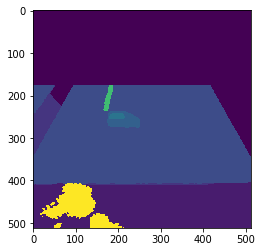

In [8]:
plt.imshow(seg)

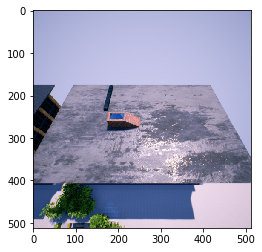

In [9]:
plt.imshow(all_images[0,:,:,:])

# Save the optimized Half precision graph

In [25]:
del sys.modules["convert_ckpt_to_pb"]
from convert_ckpt_to_pb import model_to_graph

In [4]:
input_names = ['network/input/Placeholder']
output_names = ['network/output/Softmax']

In [5]:
save_file = os.path.join(args.checkpoint_best_dir, 'final_model.pb')
drop_scope = ['Switch', 'Merge']
ops_to_convert = ['Conv2D', 
       'BiasAdd', 
       'FusedBatchNorm',
       'Conv2DBackpropInput',
       'Add','Relu6','Relu',
       'DepthwiseConv2dNative',
       'Reshape',
       'Softmax']

optimized_graph = model_to_graph(model, 
                                  ops_to_convert, 
                                  drop_scope,
                                  verbose=True, 
                                  save_file=save_file,
                                  remove_training=True,
                                   strip_nodes=True,
                                   conver_to_half=False)

INFO:tensorflow:Froze 236 variables.
INFO:tensorflow:Converted 236 variables to const ops.
original graph nodes: 1258
graph nodes after removing training: 942
Nodes hash table is built!
New graph is built!
graph nodes after stripping: 531


In [28]:
%%capture cap --no-stderr
for node in optimized_graph.node:
    print(node)
with open('output.txt', 'w') as f:
    f.write(cap.stdout)

In [6]:
'''Use TF-TRT to convert and save graph'''
trt_graph_def = trt.create_inference_graph(
        input_graph_def=optimized_graph,
        outputs=['network/output/Softmax'],
        max_batch_size=1,
        max_workspace_size_bytes=1 << 26,
        precision_mode='FP16',
        minimum_segment_size=50,
    )
with open(save_file, 'wb') as pf:
    pf.write(trt_graph_def.SerializeToString())
print(len(trt_graph_def.node))

358


In [13]:
%%capture cap --no-stderr
for node in trt_graph_def.node:
    print(node)
with open('trt_output.txt', 'w') as f:
    f.write(cap.stdout)

In [9]:
image = os.path.join(IMAGE_ROOT, '3200-0.png')
image = np.asarray(Image.open(image).resize((512,512)).convert('RGB'))
print(image.shape)

(512, 512, 3)


In [10]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

with tf.Session(config=tf_config) as tf_sess:
    tf.import_graph_def(trt_graph_def, name='')
    tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
    tf_output = tf_sess.graph.get_tensor_by_name(output_names[0] + ':0')
    output = tf_sess.run(tf_output, feed_dict={
                tf_input: image[None, ...]})

InvalidArgumentError: You must feed a value for placeholder tensor 'network/input/Placeholder_2' with dtype bool
	 [[Node: network/input/Placeholder_2 = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: network/output/Softmax/_5 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1273_network/output/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'network/input/Placeholder_2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tornado/ioloop.py", line 832, in start
    self._run_callback(self._callbacks.popleft())
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret = callback()
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tornado/gen.py", line 1152, in inner
    self.run()
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tornado/gen.py", line 1069, in run
    yielded = self.gen.send(value)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tornado/gen.py", line 307, in wrapper
    yielded = next(result)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tornado/gen.py", line 307, in wrapper
    yielded = next(result)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tornado/gen.py", line 307, in wrapper
    yielded = next(result)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-1596a4dc879b>", line 1, in <module>
    model = Segmentor(args)
  File "../semantic_segmentation.py", line 41, in __init__
    self.build_model()
  File "../utils/misc.py", line 18, in timed
    result = f(*args, **kwargs)
  File "../semantic_segmentation.py", line 51, in build_model
    self.model.build()
  File "../models/fcn8s_mobilenet.py", line 22, in build
    self.init_input()
  File "../models/basic/basic_model.py", line 118, in init_input
    self.is_training = tf.placeholder(tf.bool)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1734, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4924, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home/nvidia/home/nvidia/Envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'network/input/Placeholder_2' with dtype bool
	 [[Node: network/input/Placeholder_2 = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: network/output/Softmax/_5 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1273_network/output/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


# Test single image

In [73]:
# %%capture cap --no-stderr
# for node in new_output_graph_def.node:
#     print(node)
# with open('output.txt', 'w') as f:
#     f.write(cap.stdout)

In [ ]:
#MobileNet + FCN8s
INFO:tensorflow:Froze 190 variables.
INFO:tensorflow:Converted 190 variables to const ops.
752 ops in the final graph.

#ShuffleNet + FCN8s
INFO:tensorflow:Froze 446 variables.
INFO:tensorflow:Converted 446 variables to const ops.
2071 ops in the final graph. 

1524 ops in the final graph.

# MobileNet + Unet
INFO:tensorflow:Froze 236 variables.
INFO:tensorflow:Converted 236 variables to const ops.
942 ops in the final graph.

531 ops in the final graph.

In [12]:
all_nodes = {}
with model.sess.as_default():
     for n in tf.get_default_graph().as_graph_def().node:
        all_nodes[n.name] = n

with open("all_node_names.txt",'w') as f:
    for node in all_nodes:
        f.write(node + '\n')

In [26]:
'''Test single image'''
image = os.path.join(IMAGE_ROOT, '3566-0.png')
image = np.asarray(Image.open(image).resize((512,512)).convert('RGB'))

label = os.path.join(LABEL_ROOT, '3566-0.png')
label = np.asarray(Image.open(label).resize((512,512)))
segmentation = model.run(image)
segmentation = segmentation[0][0]

   [-] run : 0.15074 sec, which is 0.00251 mins, which is 0.00004 hours


In [6]:
'''Test multiple images'''
images = np.load(os.path.join(args.data_dir, 'X_val.npy'))

start = time.time()
for i in range(0, len(images), 1):
#     try:
    inputs = images[i:i+1,:,:,:]
    segmentations = model.run(inputs, np.zeros([1,512,512]))
    if i %100 == 0:
        print(i)
#     except:
#         pass
elipse = time.time() - start
print(elipse/i)

0
100
200
300
400
500
600
700
800
900
1000
0.10374581401164715


In [7]:
elipse

86.24232745170593

In [23]:
from utils.seg2rgb import *
cmap_list, seg2rgb_map = get_seg2rgb_map('/media/DATA/UnrealLandingDataset/AirSimCollectData/seg_rgbs.txt', 18)

In [28]:

seg_rgb = np.zeros([segmentation.shape[0], segmentation.shape[1], 3])
all_classes = np.unique(segmentation)
for i in all_classes:
    seg_rgb[np.where(segmentation == i)] = seg2rgb_map[i][:3]

gt_seg_rgb = np.zeros([label.shape[0], label.shape[1], 3])
all_gt_classes = np.unique(label)
for i in all_gt_classes:
    gt_seg_rgb[np.where(label == i)] = seg2rgb_map[i][:3]


<IPython.core.display.Javascript object>


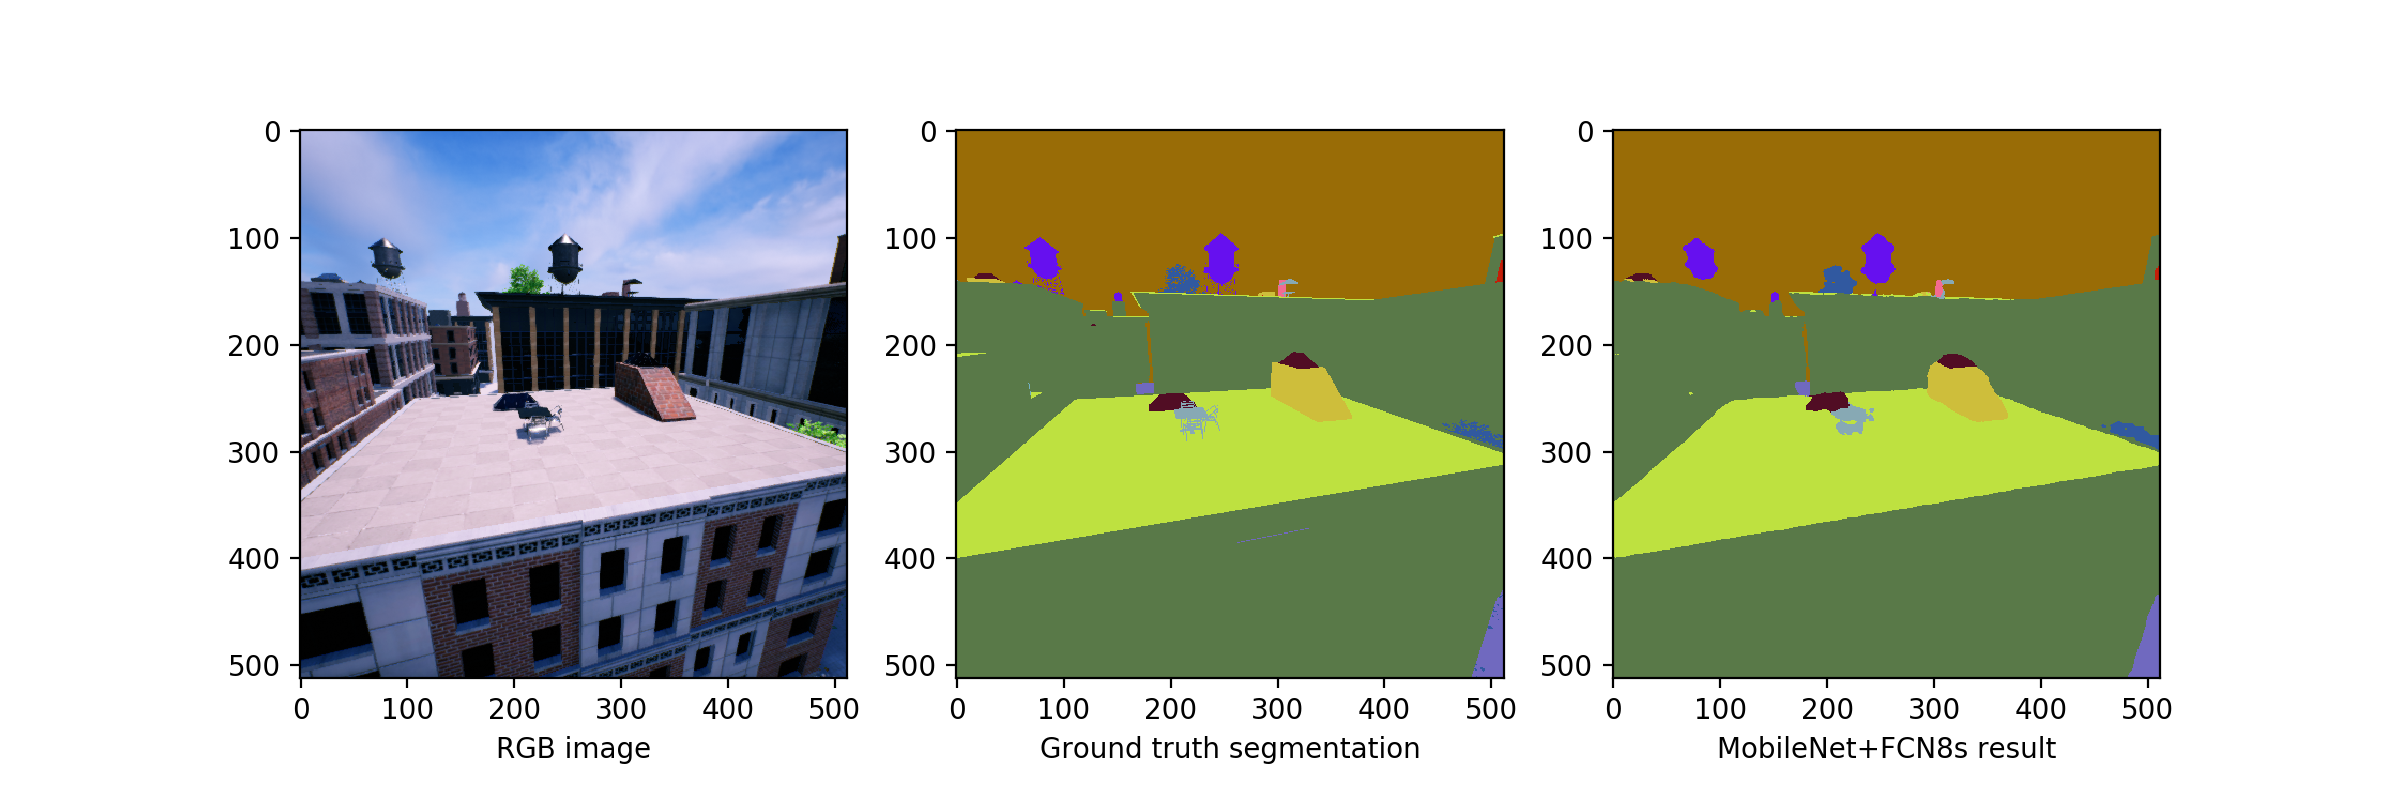

Text(0.5, 0, 'MobileNet+FCN8s result')

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.imshow(image)
ax1.set_xlabel("RGB image")
ax2.imshow(gt_seg_rgb)
ax2.set_xlabel("Ground truth segmentation")
ax3.imshow(seg_rgb)
ax3.set_xlabel("MobileNet+FCN8s result")


# Test on all validation data
* ~2000 images in X_val.npy
* compute per class IOU, mean IOU and frame rate in ms

In [6]:
DATA_ROOT = ''
X_batch = np.load(os.path.join(args.data_dir, 'X_test.npy'))
Y_batch = np.load(os.path.join(args.data_dir, 'Y_test.npy'))


In [9]:
fps_meter = FPSMeter()
for i in range(X_batch.shape[0]):
    image = X_batch[i:i+1,:,:,:]
    label = Y_batch[i:i+1,:,:]
    start = time.time()
    segmentation = model.run(image, label)
    # update the FPS meter
    fps_meter.update(time.time() - start)

    model.metrics.update_metrics(segmentation[0], label, 0, 0)
    
    if i % 100 == 0:
        print(i)

0
100


In [10]:
'''
get rid of following classes:
0 - unknown
15 - power_line
16 - street_light
17 - door
'''
nonignore = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
iou, mean_iou = model.metrics.compute_final_metrics(1, nonignore=nonignore)
fps_meter.print_statistics()


Statistics of the FPSMeter
Frame per second: 6.14 fps
Milliseconds per frame: 162.82 ms in one frame
These statistics are calculated based on
131 Frames and the whole taken time is 21.3289 Seconds
        


In [14]:
print('Dataset: ', args.data_dir)
print('Model: %s \nMean_iou: %2f ' %(args.model, mean_iou))
print("per class iou:", iou)
fps_meter.print_statistics()

Dataset:  /media/DATA/UnrealLandingDataset/AirSimCollectData/CV_Random_Histogram/
Model: FCN8sMobileNet 
Mean_iou: 0.744409 
per class iou: [0.9939692  0.9306462  0.9627078  0.9784495  0.8209259  0.78980154
 0.4809117  0.7790504  0.4248172  0.79821706 0.7444992  0.
 0.900675   0.8170603 ]

Statistics of the FPSMeter
Frame per second: 6.05 fps
Milliseconds per frame: 165.22 ms in one frame
These statistics are calculated based on
1040 Frames and the whole taken time is 171.8271 Seconds
        


In [ ]:
'''FCN8sMobileNet'''
Dataset:  /media/DATA/UnrealLandingDataset/AirSimCollectData/CV_Random_Histogram/
Model: FCN8sMobileNet 
Mean_iou: 0.744409 
per class iou: [0.9939692  0.9306462  0.9627078  0.9784495  0.8209259  0.78980154
 0.4809117  0.7790504  0.4248172  0.79821706 0.7444992  0.
 0.900675   0.8170603 ]

Statistics of the FPSMeter
Frame per second: 6.05 fps
Milliseconds per frame: 165.22 ms in one frame
These statistics are calculated based on
1040 Frames and the whole taken time is 171.8271 Seconds

'''FCN8sShuffleNet Results'''
Dataset:  /media/DATA/UnrealLandingDataset/AirSimCollectData/CV_Random_Histogram/
Model: FCN8sShuffleNet 
Mean_iou: 0.593292 
per class iou: [0.99086666 0.8868927  0.9431177  0.9681425  0.6957779  0.75316083
 0.3502395  0.6926213  0.27422947 0.6553712  0.60759914 0.
 0.8660416  0.7693265  0.0026532  0.08100874 0.5489082 ]

Statistics of the FPSMeter
Frame per second: 6.82 fps
Milliseconds per frame: 146.70 ms in one frame
These statistics are calculated based on
1040 Frames and the whole taken time is 152.5684 Seconds

'''UNetMobileNet Results'''
Dataset:  /media/DATA/UnrealLandingDataset/AirSimCollectData/CV_Random_Histogram/
Model: UNetMobileNet 
Mean_iou: 0.601225 
per class iou: [0.9960176  0.8513305  0.9539146  0.9607811  0.6875438  0.8046355
 0.36736372 0.7270763  0.30880427 0.73878676 0.73967934 0.
 0.5588881  0.8624144  0.         0.09831192 0.56527215]

Statistics of the FPSMeter
Frame per second: 3.60 fps
Milliseconds per frame: 277.62 ms in one frame
These statistics are calculated based on
1040 Frames and the whole taken time is 288.7270 Seconds

In [ ]:
'''fcn8s_mobilenet'''
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700

Statistics of the FPSMeter
Frame per second: 6.45 fps
Milliseconds per frame: 155.11 ms in one frame
These statistics are calculated based on
1720 Frames and the whole taken time is 266.7856 Seconds

'''fcn8s_shufflenet'''
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700

Statistics of the FPSMeter
Frame per second: 6.43 fps
Milliseconds per frame: 155.49 ms in one frame
These statistics are calculated based on
1720 Frames and the whole taken time is 267.4394 Seconds

array([0.9819374 , 0.92100424, 0.9454226 , 0.97071713, 0.8919036 ,
       0.8143741 , 0.4096751 , 0.8093338 , 0.65112555, 0.7875616 ,
       0.7752347 , 0.8792261 , 0.90480435, 0.8371956 , 0.03003817,
       0.2609902 , 0.72130483], dtype=float32)